# Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, print_code, my_collate
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, VilBertVisualBertModel
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment, DefinedAffine, DefinedColorJitter, DefinedRandomPerspective
from facebook_hateful_memes_detector.preprocessing import DefinedAffine, HalfSwap, get_image_transforms, get_transforms_for_bbox_methods
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:


def get_preprocess_text():
    char_level = {
        "keyboard": 0.1,
        "char_substitute": 0.4,
        "char_insert": 0.2,
        "char_swap": 0.2,
        "ocr": 0.0,
        "char_delete": 0.1
    }
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {
        "fasttext": 0.0,
        "glove_twitter": 0.0,
        "glove_wiki": 0.0,
        "word2vec": 0.0,
        "split": 0.2,
        "stopword_insert": 0.0,
        "word_join": 0.2,
        "word_cutout": 0.8,
        "gibberish_insert": 0.0
    }
    word_level = TextAugment([0.2, 0.7, 0.1], word_level)
    sentence_level = {
        "text_rotate": 0.0,
        "sentence_shuffle": 0.0,
        "one_third_cut": 0.3,
        "half_cut": 0.0,
        "part_select": 0.75
    }
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    gibberish = {
        "gibberish_insert": 0.25,
        "punctuation_insert": 0.75,
    }
    gibberish = TextAugment([0.75, 0.25], gibberish)

    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        text = gibberish(text)
        return text

    return process


preprocess_text = get_preprocess_text()
transforms_for_bbox_methods = get_transforms_for_bbox_methods()


data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=transforms_for_bbox_methods, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = True, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

# ImageAugment([0.2, 0.5, 0.3])


In [3]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2,
                  momentum=0.9,
                  dampening=0,
                  weight_decay=0,
                  nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,
)

adam = torch.optim.Adam
adam_params = params = dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,
)

qhadam = optim.QHAdam
qhadam_params = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,
)

radam = optim.RAdam
radam_params = dict(
    lr=1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
)

yogi = optim.Yogi
yogi_params = dict(lr=1e-2,
                   betas=(0.9, 0.999),
                   eps=1e-3,
                   initial_accumulator=1e-6,
                   weight_decay=0)

In [4]:
batch_size=96
epochs = 10
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_class = adamw
optimizer_params = adamw_params


scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()




# Finetune Configs

In [5]:
lxmert_strategy = {
    "lxmert": {
        "model": {
            "bert": {
                "encoder": {
                    "x_layers": {
                        "lr": optimizer_params["lr"],
                        "finetune": True
                    },
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "pooler": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
            },
            "finetune": False
        }
    }
}

lxmert_strategy = {
    "finetune": True
}




## LXMERT

In [6]:
model_params = dict(
    model_name={"lxmert": dict(dropout=0.1, gaussian_noise=0.01)},
    num_classes=2,
    gaussian_noise=0.01,
    dropout=0.05,
    word_masking_proba=0.15,
    featurizer="pass",
    final_layer_builder=fb_1d_loss_builder,
    internal_dims=768,
    classifier_dims=768,
    n_tokens_in=96,
    n_tokens_out=96,
    n_layers=0,
    attention_drop_proba=0.0,
    loss="focal",
    dice_loss_coef=0.0,
    auc_loss_coef=0.0,
    bbox_swaps=1,
    bbox_copies=1,
    bbox_gaussian_noise=0.01,
    finetune=False)

from facebook_hateful_memes_detector.models.MultiModal.VilBertVisualBert import VilBertVisualBertModel




model_fn = model_builder(VilBertVisualBertModel,
                         model_params,
                         per_param_opts_fn=lxmert_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)



In [7]:
model, optimizer = model_fn()
model.load_state_dict(torch.load("lxmert-smclr.pth"))
model = model.to(get_device())


LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load LXMERT pre-trained model from /home/ahemf/.pytorch_pretrained_bert/acfabf2c6d3708e226675d880fed09a14878ef2aee577eeefa8e27a6a22d5b3e.5392626539fa4619737ae314ee55e15de3097750e782865c604a83312ea77251

Weights in loaded but not in model:
answer_head.logit_fc.0.bias
answer_head.logit_fc.0.weight
answer_head.logit_fc.2.bias
answer_head.logit_fc.2.weight
answer_head.logit_fc.3.bias
answer_head.logit_fc.3.weight
cls.predictions.bias
cls.predictions.decoder.weight
cls.predictions.transform.LayerNorm.bias
cls.predictions.transform.LayerNorm.weight
cls.predictions.transform.dense.bias
cls.predictions.transform.dense.weight
cls.seq_relationship.bias
cls.seq_relationship.weight
obj_predict_head.decoder_dict.attr.bias
obj_predict_head.decoder_dict.attr.weight
obj_predict_head.decoder_dict.feat.bias
obj_predict_head.decoder_dict.feat.weight
obj_predict_head.decoder_dict.obj.bias
obj_predict_head.decoder_dict.obj.weight
obj_predict_head.tr

Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  132 Classifier Dims =  768 Matches embedding_dims:  True


<All keys matched successfully>

In [ ]:
batch_size=64
epochs = 10

kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[2, 5, 7, 9, 11, 14, 17, 19, 24, 28],
    show_model_stats=False,
    sampling_policy="without_replacement",
    accumulation_steps=4,
)
r1, p1 = results, prfs
results
prfs



Autocast =  True Epochs =  20 Divisor = 2 Examples = 4250 Batch Size =  64
Training Samples =  8500 Weighted Sampling =  True Num Batches =  67 Accumulation steps =  4
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.


Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401

LXMERTFeatureExtractor : Loaded Model...

Epoch =  1 Loss = 0.275041 LR = 0.00001667



Epoch =  2 Loss = 0.207471 LR = 0.00003333



scores =  {'map': '0.4508', 'acc': '0.6396', 'auc': '0.6048'}


Proba       Preds    
         min   max   min max
Labels                      
0      0.420 0.562     0   1
1      0.425 0.581     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.474,"[0.5255845785140991, 0.47441545128822327]",0,0,0.464,"[0.5358601212501526, 0.464139848947525]",0,0,0.465,"[0.5347846746444702, 0.4652153551578522]",0,0
1,0.458,"[0.5422555208206177, 0.4577445089817047]",0,1,0.504,"[0.49587568640708923, 0.5041243433952332]",1,0,0.541,"[0.45929381251335144, 0.5407061576843262]",1,0
2,0.485,"[0.5146709084510803, 0.4853290617465973]",0,0,0.505,"[0.49527186155319214, 0.5047281384468079]",1,1,0.464,"[0.5361254215240479, 0.4638745188713074]",0,0
3,0.486,"[0.5138347148895264, 0.48616528511047363]",0,1,0.457,"[0.5434409379959106, 0.4565589725971222]",0,1,0.562,"[0.4376048445701599, 0.5623952150344849]",1,0
4,0.469,"[0.5310927033424377, 0.46890732645988464]",0,0,0.472,"[0.5283909440040588, 0.4716089963912964]",0,0,0.440,"[0.5600056052207947, 0.4399944245815277]",0,1


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,227,23,250.000,90.000
1,222,28,250.000,11.000
Predicted Counts,449,51,500.000,nan
Precision %,50,54,nan,nan


scores =  {'map': '0.5373', 'acc': '0.5100', 'auc': '0.5336'}
Epoch =  2 Train = ['45.08', '63.96', '60.48'] Val = ['53.73', '51.00', '53.36']



Epoch =  3 Loss = 0.196101 LR = 0.00005000


In [15]:
model, optimizer = model_fn()
model.load_state_dict(torch.load("lxmert-smclr.pth"))
model = model.to(get_device())

batch_size=64
epochs = 15

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[2, 5, 7, 9, 11, 14, 17, 19, 24, 28],
    show_model_stats=False,
    sampling_policy="without_replacement",
    accumulation_steps=4,
)
r3, p3 = results, prfs
results
prfs



LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load LXMERT pre-trained model from /home/ahemf/.pytorch_pretrained_bert/acfabf2c6d3708e226675d880fed09a14878ef2aee577eeefa8e27a6a22d5b3e.5392626539fa4619737ae314ee55e15de3097750e782865c604a83312ea77251

Weights in loaded but not in model:
answer_head.logit_fc.0.bias
answer_head.logit_fc.0.weight
answer_head.logit_fc.2.bias
answer_head.logit_fc.2.weight
answer_head.logit_fc.3.bias
answer_head.logit_fc.3.weight
cls.predictions.bias
cls.predictions.decoder.weight
cls.predictions.transform.LayerNorm.bias
cls.predictions.transform.LayerNorm.weight
cls.predictions.transform.dense.bias
cls.predictions.transform.dense.weight
cls.seq_relationship.bias
cls.seq_relationship.weight
obj_predict_head.decoder_dict.attr.bias
obj_predict_head.decoder_dict.attr.weight
obj_predict_head.decoder_dict.feat.bias
obj_predict_head.decoder_dict.feat.weight
obj_predict_head.decoder_dict.obj.bias
obj_predict_head.decoder_dict.obj.weight
obj_predict_head.t

Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  132 Classifier Dims =  256 Matches embedding_dims:  False
Autocast =  True Epochs =  30 Divisor = 2 Examples = 4250 Batch Size =  64
Training Samples =  8500 Weighted Sampling =  True Num Batches =  67 Accumulation steps =  4
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.



Epoch =  1 Loss = 0.287965 LR = 0.00001111



Epoch =  2 Loss = 0.242440 LR = 0.00002222


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch =  15 Loss = 0.166423 LR = 0.00008117



Epoch =  16 Loss = 0.163380 LR = 0.00007500



Epoch =  17 Loss = 0.153666 LR = 0.00006827


Proba       Preds    
         min   max   min max
Labels                      
0      0.254 0.715     0   1
1      0.293 0.670     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.506,"[0.4942636489868164, 0.5057363510131836]",1,1,0.547,"[0.45323070883750916, 0.5467692613601685]",1,1,0.556,"[0.444079726934433, 0.5559202432632446]",1,1
1,0.445,"[0.5554651021957397, 0.44453492760658264]",0,0,0.588,"[0.41242650151252747, 0.5875735282897949]",1,0,0.492,"[0.5079047679901123, 0.4920952618122101]",0,1
2,0.448,"[0.5516527891159058, 0.44834715127944946]",0,1,0.535,"[0.46505171060562134, 0.5349482893943787]",1,1,0.464,"[0.5357080698013306, 0.46429190039634705]",0,1
3,0.621,"[0.3788388669490814, 0.6211611032485962]",1,0,0.357,"[0.6431190371513367, 0.35688093304634094]",0,0,0.463,"[0.5369923114776611, 0.4630076587200165]",0,0
4,0.471,"[0.5292916297912598, 0.47070831060409546]",0,1,0.321,"[0.6793841123580933, 0.3206159174442291]",0,1,0.378,"[0.6219660639762878, 0.3780338764190674]",0,1


scores =  {'map': '0.5932', 'acc': '0.5620', 'auc': '0.6050'}
Epoch =  17 Train = 0.850991 Val = 0.605040



Epoch =  18 Loss = 0.146578 LR = 0.00006113



Epoch =  19 Loss = 0.145620 LR = 0.00005374


Proba       Preds    
         min   max   min max
Labels                      
0      0.195 0.754     0   1
1      0.274 0.703     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.602,"[0.39847663044929504, 0.6015233397483826]",1,0,0.418,"[0.581577718257904, 0.4184223413467407]",0,0,0.439,"[0.5609560012817383, 0.4390439987182617]",0,1
1,0.601,"[0.39876899123191833, 0.6012309789657593]",1,1,0.448,"[0.5522605180740356, 0.44773954153060913]",0,0,0.623,"[0.37726902961730957, 0.6227309703826904]",1,1
2,0.543,"[0.45687395334243774, 0.543126106262207]",1,1,0.556,"[0.44418618083000183, 0.5558137893676758]",1,1,0.483,"[0.5171107649803162, 0.4828892648220062]",0,0
3,0.629,"[0.37103071808815, 0.6289693117141724]",1,1,0.637,"[0.3629057705402374, 0.637094259262085]",1,1,0.310,"[0.6899725198745728, 0.31002748012542725]",0,1
4,0.356,"[0.6437317132949829, 0.3562682867050171]",0,0,0.492,"[0.507634699344635, 0.49236536026000977]",0,1,0.597,"[0.40340980887413025, 0.5965901613235474]",1,1


scores =  {'map': '0.6070', 'acc': '0.5760', 'auc': '0.6228'}
Epoch =  19 Train = 0.868995 Val = 0.622784



Epoch =  20 Loss = 0.142240 LR = 0.00004626



Epoch =  21 Loss = 0.141257 LR = 0.00003887



Epoch =  22 Loss = 0.136900 LR = 0.00003173



Epoch =  23 Loss = 0.139276 LR = 0.00002500



Epoch =  24 Loss = 0.135749 LR = 0.00001883


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Predict

In [6]:
adam = torch.optim.Adam
adam_params = params = dict(lr=1e-4, weight_decay=1e-2)
optimizer = adam
optimizer_params = adam_params

model_fn = model_builder(VilBertVisualBertModel,
                         dict(model_name={
                             "lxmert":
                             dict(finetune=True,
                                  dropout=0.1,
                                  gaussian_noise=0.2),
                            },
                              num_classes=2,
                              gaussian_noise=0.2,
                              dropout=0.25,
                              featurizer="pass",
                              final_layer_builder=fb_1d_loss_builder,
                              internal_dims=768,
                              classifier_dims=768,
                              n_tokens_in=96,
                              n_tokens_out=96,
                              n_layers=2,
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              word_masking_proba=0.2),
                         per_param_opts_fn=combo_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

# model, opt = model_fn()
# model

##
## MMBT Region, Per module regularization, word_masking_proba, reg_scheduling

## Next accumulation_steps


Overriding option config to projects/hateful_memes/configs/vilbert/from_cc.yaml
Overriding option model to vilbert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to vilbert.finetuned.hateful_memes.from_cc_original
Overriding option evaluation.predict to true


Some weights of the model checkpoint at bert-base-uncased were not used when initializing ViLBERTBase: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing ViLBERTBase from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ViLBERTBase from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViLBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.v_embeddings.image_embeddings.weight', 'bert.v_embeddings.image_embeddings.bias', 'bert.v_embeddings.image_location_embeddings.weight', 'bert.v_embeddings.image_location_embeddings.bias', 'bert.v_embeddings.LayerNorm.weight', 'bert.v_embeddings.LayerNorm.

Overriding option config to projects/hateful_memes/configs/visual_bert/from_coco.yaml
Overriding option model to visual_bert
Overriding option datasets to hateful_memes
Overriding option run_type to val
Overriding option checkpoint.resume_zoo to visual_bert.finetuned.hateful_memes.from_coco
Overriding option evaluation.predict to true


Some weights of VisualBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.embeddings.token_type_embeddings_visual.weight', 'bert.embeddings.position_embeddings_visual.weight', 'bert.embeddings.projection.weight', 'bert.embeddings.projection.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LXRT encoder with 9 l_layers, 5 x_layers, and 5 r_layers.
Load LXMERT pre-trained model from /home/ahemf/.pytorch_pretrained_bert/acfabf2c6d3708e226675d880fed09a14878ef2aee577eeefa8e27a6a22d5b3e.5392626539fa4619737ae314ee55e15de3097750e782865c604a83312ea77251

Weights in loaded but not in model:
answer_head.logit_fc.0.bias
answer_head.logit_fc.0.weight
answer_head.logit_fc.2.bias
answer_head.logit_fc.2.weight
answer_head.logit_fc.3.bias
answer_head.logit_fc.3.weight
cls.predictions.bias
cls.predictions.decoder.weight
cls.predictions.transform.LayerNorm.bias
cls.predictions.transform.LayerNorm.weight
cls.predictions.transform.dense.bias
cls.predictions.transform.dense.weight
cls.seq_relationship.bias
cls.seq_relationship.weight
obj_predict_head.decoder_dict.attr.bias
obj_predict_head.decoder_dict.attr.weight
obj_predict_head.decoder_dict.feat.bias
obj_predict_head.decoder_dict.feat.weight
obj_predict_head.decoder_dict.obj.bias
obj_predict_head.decoder_dict.obj.weight
obj_predict_head.tr

Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


N tokens Out =  722
Autocast =  True Epochs =  14 Divisor = 2 Examples = 4500 Batch Size =  4
Training Samples =  9000 Weighted Sampling =  True Num Batches =  1125 Accumulation steps =  16
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.


FeatureExtractor : Loaded Model...
LXMERTFeatureExtractor : Loaded Model...

Epoch =  1 Loss = 0.229189 LR = 0.00023810


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch =  4 Loss = 0.140130 LR = 0.00095238


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch =  7 Loss = 0.154248 LR = 0.00081174



Epoch =  8 Loss = 0.157731 LR = 0.00067268



Epoch =  9 Loss = 0.158405 LR = 0.00051603



Epoch =  10 Loss = 0.153493 LR = 0.00035774



Epoch =  11 Loss = 0.152576 LR = 0.00021394



Epoch =  12 Loss = 0.153589 LR = 0.00009929



Epoch =  13 Loss = 0.147211 LR = 0.00002547



Epoch =  14 Loss = 0.145344 LR = 0.00000000



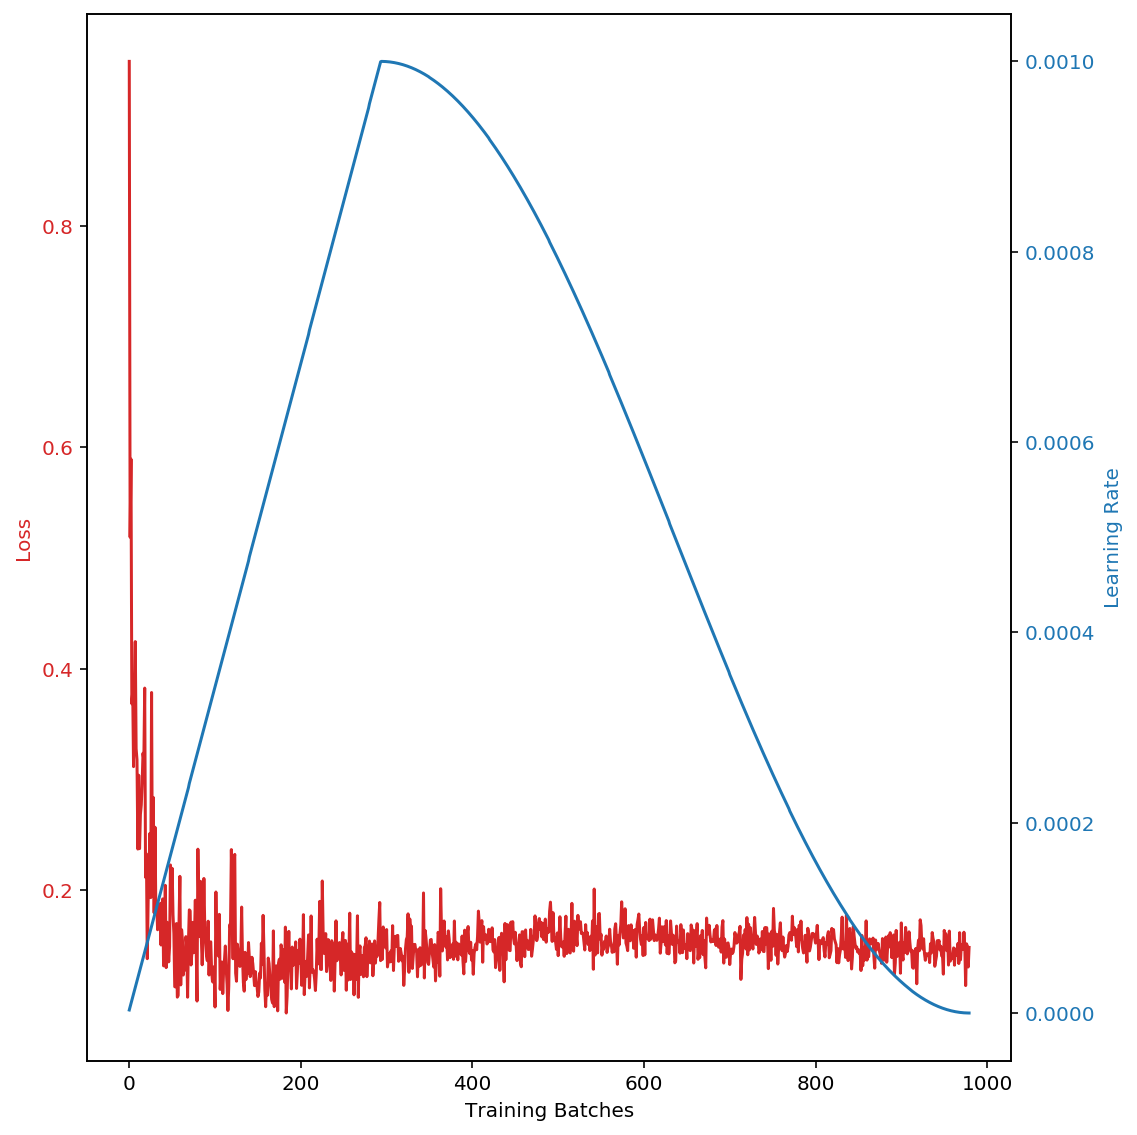

,id,proba,label
655,84517,0.511,1
433,71063,0.671,1
414,85042,0.613,1


In [7]:

torch.backends.cudnn.enabled = False
batch_size = 4
epochs = 7

submission, text_model = train_and_predict(
    model_fn,
    data,
    batch_size,
    epochs,
    scheduler_init_fn=scheduler_init_fn,
    accumulation_steps=16,
    model_call_back=reg_sched,
    sampling_policy="without_replacement") # "without_replacement"

submission.to_csv("submission.csv", index=False)
submission.sample(3)


In [8]:
data["test"] = data["dev"]
sf, _ = predict(text_model, data, batch_size)

print(sf.head())

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

labels_list = data["test"].label
proba_list = sf.proba
predictions_list = sf.label

auc = roc_auc_score(labels_list, proba_list)
# p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(labels_list, predictions_list, average="micro")
prfs = precision_recall_fscore_support(labels_list, predictions_list, average=None, labels=[0, 1])
map = average_precision_score(labels_list, proba_list)
acc = accuracy_score(labels_list, predictions_list)
validation_scores = [map, acc, auc]
print("scores = ", dict(zip(["map", "acc", "auc"], ["%.4f" % v for v in validation_scores])))



      id  proba  label
0   8291  0.632      1
1  46971  0.350      0
2   3745  0.543      1
3  83745  0.594      1
4  80243  0.617      1
scores =  {'map': '0.6912', 'acc': '0.6920', 'auc': '0.7407'}


In [ ]:
submission.sample(10)
submission.label.value_counts()

In [ ]:


batch_size = 32
epochs = 7

submission, text_model = train_and_predict(
    model_fn,
    data,
    batch_size,
    epochs,
    scheduler_init_fn=scheduler_init_fn,
    accumulation_steps=1,
    model_call_back=reg_sched,
    sampling_policy=None) # "without_replacement"

submission.to_csv("submission2.csv", index=False)
submission.sample(3)
